# Interactive Table and Histogram of Roman Amphitheater Capacities

Manually execute the three cells in order or "Run All". That will load the jsonld+geojson encoded data and then create an interactive interface to setting which amphitheaters capacities appear in a table and histogram at the bottom of the page. Slide the sliders and click the checkbox to make changes. Display refresh is clunky, but it works.

Note: If you're running this in Binder, you might get warnings about module compatibility. Should be OK to ignore those, or at least was in Summer of 2018.

To view this data as a map see:

https://github.com/sfsheath/roman-amphitheaters/blob/master/roman-amphitheaters.geojson

In [1]:
from ipywidgets import widgets,interact
from IPython.display import display, HTML, clear_output
from urllib.request import urlopen
from rdflib import Graph, plugin

import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1) # so that full Pleiades URIs are displayed

In [2]:
# jsonld+geojson amphitheater data
json_data = urlopen("http://sfsheath.github.io/roman-amphitheaters/roman-amphitheaters.geojson")
g = Graph().parse(data=json_data.read(), format='json-ld')

IntSlider(value=51000, continuous_update=False, description='Upper limit:', max=55000, min=2000, step=1000)

IntSlider(value=3000, continuous_update=False, description='Lower limit:', max=55000, min=2000, step=1000)

Checkbox(value=True, description='Sort high to low')

,title,capacity,pleiades
56,Flavian Amphitheater at Rome,50000,https://pleiades.stoa.org/places/423025hihi
106,Imperial Amphitheater at Capua,37000,https://pleiades.stoa.org/places/432754hihi
46,Flavian Amphitheater at Pozzuoli,35700,https://pleiades.stoa.org/places/432815hihi
82,Amphitheater at Thysdrus,35000,https://pleiades.stoa.org/places/324835hihi
23,Amphitheater at Tours,34000,https://pleiades.stoa.org/places/138255hihi
66,Amphitheater at Milan,31649,https://pleiades.stoa.org/places/383706hihi
41,Amphitheater at Metz,30000,https://pleiades.stoa.org/places/108928hihi
78,Amphitheater at Carthage,30000,https://pleiades.stoa.org/places/314921hihi
55,Amphitheater at Verona,30000,https://pleiades.stoa.org/places/383816hihi
2,Amphitheater at Syracuse,28773,https://pleiades.stoa.org/places/462503hihi


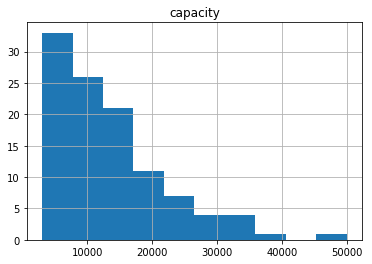

In [3]:
# function that handles changes to sliders and creates histogram
def on_value_change(change=1): # change isn't used but will be passewd so there has to be a placeholder
    global low_widget, high_widget, lower_range, upper_range, sort_widget
    
    # provide defaults if values not defined
    try:
        lower_range = low_widget.value
        upper_range = high_widget.value
        sort_order = sort_widget.value
    except NameError:
        lower_range = 3000
        upper_range = 51000
        sort_order = True
        
# The SPARQL Query
    results = g.query("""
PREFIX ramphs: <http://purl.org/roman-amphitheaters/resource/>
PREFIX gj: <https://purl.org/geojson/vocab#>
PREFIX ramphs-p: <http://purl.org/roman-amphitheaters/properties#>
PREFIX dcterms: <http://purl.org/dc/terms/>
SELECT ?title ?capacity ?pleiades WHERE {

?s gj:properties/dcterms:title ?title ;
   gj:properties/ramphs-p:capacity/ramphs-p:quantity ?capacity ;
   gj:properties/ramphs-p:pleiades ?pleiades
   .

FILTER ((?capacity > %s) )
FILTER (?capacity < %s)
}""" % (lower_range, upper_range ) )

    # build pandas dataframe
    titles, caps, pleiades = [],[],[]
    for row in results:
        titles.append(row.title)
        caps.append(int(row.capacity))
        pleiades.append('<a href="{0}" target="_new">{0}hihi</a>'.format(row.pleiades))
        
    ramphs_pd = pd.DataFrame({'title':titles,'capacity':caps,'pleiades':pleiades})
    
    # build/display interface, table, and histogram
    clear_output()
    low_widget = widgets.IntSlider(value=lower_range,
                               min=2000, max=55000,
                               step = 1000,
                               description="Lower limit:",
                               continuous_update=False)
    high_widget = widgets.IntSlider(value=upper_range,
                               min=2000, max=55000,
                               step = 1000,
                               description="Upper limit:",
                               continuous_update=False)
    sort_widget = widgets.Checkbox(description="Sort high to low", value=sort_order)
    low_widget.observe(on_value_change, names='value')
    high_widget.observe(on_value_change, names='value')
    sort_widget.observe(on_value_change, names='value')
    
    display(high_widget,
            low_widget,
            sort_widget,
            HTML(ramphs_pd.sort_values(by='capacity',
                                       ascending = not sort_order).\
                                       head(10).to_html(escape=False)))
    ramphs_pd.hist() # for now, works better outside of call to display()

# call function that gets the ball rolling,
on_value_change()